<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Clean-Clean Entity Resolution Notebook</b> </font>
   <hr>
</div>

In [30]:
!python --version

Python 3.10.9


In [31]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation, write
from pyjedai.datamodel import Data
d1 = pd.read_csv("./data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("./data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("./data/ccer/D2/gt.csv", sep='|', engine='python')

data = Data(
    dataset_1=d1,
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=gt,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Block Building

In [32]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
)

In [33]:
qgb = QGramsBlocking(qgrams=6)
blocks = qgb.build_blocks(data, attributes_1=['name'], attributes_2=['name'])

Q-Grams Blocking:   0%|          | 0/2152 [00:00<?, ?it/s]

In [34]:
qgb.evaluate(blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 6
Runtime: 0.0747 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.32% 
	Recall:        99.91%
	F1-score:       0.63%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1075
	False positives: 337743
	True negatives: 820032
	False negatives: 1
	Total comparisons: 338818
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 0.3172794833804579,
 'Recall %': 99.90706319702602,
 'F1 %': 0.6325501479873138,
 'True Positives': 1075,
 'False Positives': 337743,
 'True Negatives': 820032,
 'False Negatives': 1}

# Block Cleaning

In [35]:
from pyjedai.block_cleaning import BlockFiltering

In [36]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(blocks, data, tqdm_disable=False)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

# Comparison Cleaning


In [37]:
from pyjedai.block_cleaning import BlockPurging

In [38]:
cbbp = BlockPurging()
cleaned_blocks = cbbp.process(filtered_blocks, data, tqdm_disable=False)

Block Purging:   0%|          | 0/4852 [00:00<?, ?it/s]

In [39]:
cbbp.evaluate(cleaned_blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 3780.0
Runtime: 0.0207 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.86% 
	Recall:        98.23%
	F1-score:       1.71%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1057
	False positives: 121348
	True negatives: 1036409
	False negatives: 19
	Total comparisons: 122405
──────────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 0.8635268167150035,
 'Recall %': 98.23420074349443,
 'F1 %': 1.7120042759614837,
 'True Positives': 1057,
 'False Positives': 121348,
 'True Negatives': 1036409,
 'False Negatives': 19}

# Progressive Entity Matching

Applies Entity Matching to a subset of candidate pairs based on prioritization scheme.

In [49]:
from pyjedai.prioritization import (
    GlobalTopPM,
    LocalTopPM,
    EmbeddingsNNBPM,
    GlobalPSNM,
    LocalPSNM,
    RandomPM,
    PESM
)

In [50]:
%%time
LTPM = LocalTopPM(
    budget = 10000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

ltpm_pairs_graph = LTPM.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 2.6 s, sys: 20.1 ms, total: 2.62 s
Wall time: 2.59 s


In [51]:
%%time
GTPM = GlobalTopPM(
    budget = 10000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

gtpm_pairs_graph = GTPM.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 1.37 s, sys: 8.07 ms, total: 1.38 s
Wall time: 1.37 s


In [52]:
%%time
GPSNM = GlobalPSNM(
    budget = 10000,
    pwScheme = 'ID',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

gpsnm_pairs_graph = GPSNM.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 392 ms, sys: 15 µs, total: 392 ms
Wall time: 394 ms


In [53]:
%%time
LPSNM = LocalPSNM(
    budget = 10000,
    pwScheme = 'ID',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

lpsnm_pairs_graph = LPSNM.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 71 ms, sys: 0 ns, total: 71 ms
Wall time: 70.9 ms


In [54]:
%%time
ENNBPM = EmbeddingsNNBPM(
    budget = 10000,
    vectorizer = 'roberta',
    similarity_search = 'faiss',
    emission= 'avg',
    metric = 'dice',
    tokenizer = 'white_space_tokenizer',
    similarity_threshold = 0.1
)
ennbpm_pairs_graph = ENNBPM.predict(cleaned_blocks, data, tqdm_disable=True)

Embeddings-NN Block Building [roberta, faiss]:   0%|          | 0/2152 [00:00<?, ?it/s]

Device selected:  cpu
Loading embeddings from file...
Loading file:  .embeddings/d1_1.npy
Embeddings not found. Creating new ones.
Loading file:  .embeddings/d2_2.npy
Embeddings not found. Creating new ones.
Loading embeddings from file finished


KeyboardInterrupt: 

In [141]:
import numpy as np
print(np.load('.embeddings/d1_1.npy').shape)

(100, 768)


In [55]:
%%time
rpm = RandomPM(
    budget = 10000,
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

rpm_pairs_graph = rpm.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 35.5 ms, sys: 37 µs, total: 35.6 ms
Wall time: 34.9 ms


In [56]:
%%time
pesm = PESM(
    budget = 10000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

pesm_pairs_graph = pesm.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 6.2 s, sys: 47.9 ms, total: 6.25 s
Wall time: 6.24 s


In [57]:
def reverse(id1, id2):
    if(id1 > id2):
        return (id2, id1)
    else:
        return (id1, id2)

def get_duplicates(tuple_list):
    count = 0
    seen_pairs = set()
    duplicates = []
    
    for item in tuple_list:
        weight, id1, id2 = item
        pair = reverse(id1, id2)
        
        if pair in seen_pairs:
            dupl.append(pair)
        else:
            seen_pairs.add(pair)
    
    return duplicates

In [58]:
# some progressive methods don't allow for comparison storage within graph
# it changes the order of the emitted pairs
methods_prediction_data = []

# ltpm_pairs_graph.edges = sorted(ltpm_pairs_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
# gtpm_pairs_graph.edges = sorted(gtpm_pairs_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

# ltpm_pairs_graph.edges = [edge[:2] for edge in ltpm_pairs_graph.edges]
# gtpm_pairs_graph.edges = [edge[:2] for edge in gtpm_pairs_graph.edges]


# ltpm_pairs_graph
# gtpm_pairs_graph
# rpm_pairs_graph
# gpsnm_pairs_graph
# lpsnm_pairs_graph
# pesm_pairs_graph

methods_prediction_data.append(("Random", [edge for edge in rpm_pairs_graph.edges]))
methods_prediction_data.append(("Local Top", [edge[:2] for edge in ltpm_pairs_graph.edges]))
methods_prediction_data.append(("Global Top", [edge[:2] for edge in gtpm_pairs_graph.edges]))
methods_prediction_data.append(("GSN", gpsnm_pairs_graph))
methods_prediction_data.append(("LSN", lpsnm_pairs_graph))
methods_prediction_data.append(("ES", pesm_pairs_graph))
# methods_prediction_data.append(("ENNBPM", ennbpm_pairs_graph))

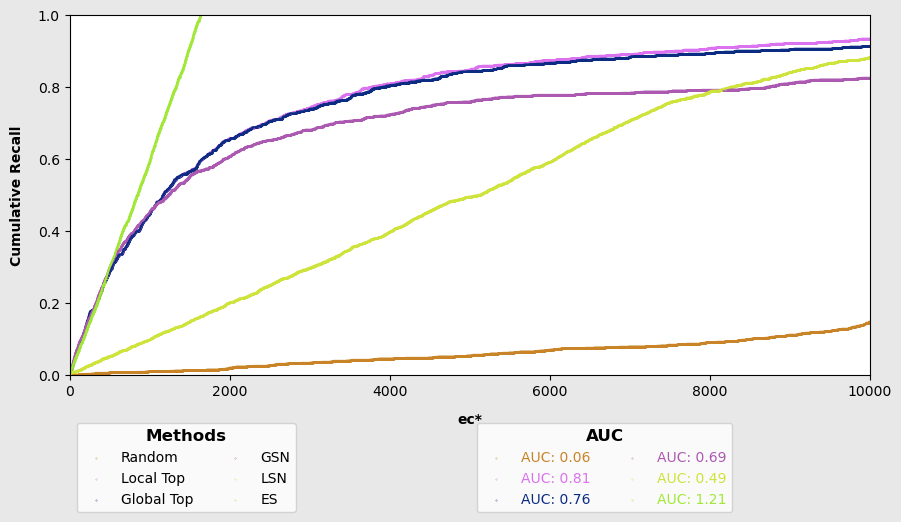

CPU times: user 402 ms, sys: 3.94 ms, total: 406 ms
Wall time: 413 ms


In [59]:
%%time
GPSNM.evaluate_auc_roc(methods_prediction_data = methods_prediction_data, proportional = False)

# Entity Clustering

It takes as input the similarity graph produced by Entity Matching and partitions it into a set of equivalence clusters, with every cluster corresponding to a distinct real-world object.

In [ ]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering

In [ ]:
ccc = ConnectedComponentsClustering()
clusters = ccc.process(pairs_graph, data)

In [ ]:
ccc.evaluate(clusters, with_classification_report=True)

In [ ]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering
umc = UniqueMappingClustering()
clusters = umc.process(pairs_graph, data)

In [ ]:
umc.evaluate(clusters, with_classification_report=True)